In [1]:
import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import networkx as nx
import sys

from torch_geometric.datasets import TUDataset
from torch_geometric.utils import to_dense_adj

from preprocess import *
from utils import *
from model import *
from train import *

/Users/stella/anaconda3/envs/gdl/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load Dataset
dataset = TUDataset(root='data/TUDataset', name='Mutagenicity')

print()
print(f'Dataset: {dataset}:')
print('====================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

torch.manual_seed(12345)

# Train test split
train_split = 0.8
batch_size = 16
visual_batch_size = 200
train_loader, val_loader, test_loader, visual_data_loader = prepare_data(dataset, train_split, batch_size, visual_batch_size)


Dataset: Mutagenicity(4337):
Number of graphs: 4337
Number of features: 14
Number of classes: 2

Class split - Training 0: 1901 1: 1568, Validation 0: 255 1: 179, Test 0: 245 1: 189


### Model Training

Epoch 1, Train Loss: 3.4123, Val Loss: 0.6041, Val Acc: 0.6797
Epoch 2, Train Loss: 2.8435, Val Loss: 0.5724, Val Acc: 0.6959
Epoch 3, Train Loss: 2.4276, Val Loss: 0.5545, Val Acc: 0.7097
Epoch 4, Train Loss: 2.0572, Val Loss: 0.5258, Val Acc: 0.7304
Epoch 5, Train Loss: 1.7638, Val Loss: 0.5791, Val Acc: 0.7419
Epoch 6, Train Loss: 1.5727, Val Loss: 0.5173, Val Acc: 0.7535
Epoch 7, Train Loss: 1.4078, Val Loss: 0.5483, Val Acc: 0.7396
Epoch 8, Train Loss: 1.2681, Val Loss: 0.5063, Val Acc: 0.7742
Epoch 9, Train Loss: 1.1793, Val Loss: 0.5749, Val Acc: 0.7304
Epoch 10, Train Loss: 1.1090, Val Loss: 0.4787, Val Acc: 0.7903
Epoch 11, Train Loss: 1.0290, Val Loss: 0.5193, Val Acc: 0.7696
Epoch 12, Train Loss: 0.9782, Val Loss: 0.5223, Val Acc: 0.7995
Epoch 13, Train Loss: 0.9367, Val Loss: 0.4967, Val Acc: 0.7903
Epoch 14, Train Loss: 0.8912, Val Loss: 0.5475, Val Acc: 0.7765
Epoch 15, Train Loss: 0.8655, Val Loss: 0.5015, Val Acc: 0.7834
Epoch 16, Train Loss: 0.8409, Val Loss: 0.5041, V

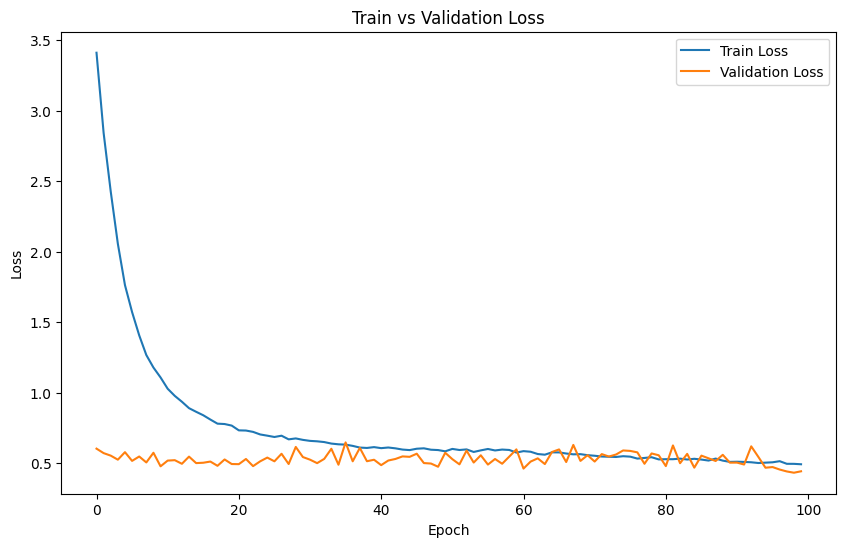

In [3]:
# Define the model
num_hidden_unit = 32
num_nodes1 = 8
num_nodes2 = 4
model = DiffPoolGNN(dataset.num_features, num_hidden_unit, dataset.num_classes, num_nodes1, num_nodes2)

# Training

lr = 0.001
epochs = 100
model_checkpoint = 'model_state_32_8_4.pth'

experiment_runner(model, train_loader, val_loader, lr, epochs, model_checkpoint)

### Load trained model

In [5]:
num_hidden_unit = 32
num_nodes1 = 8
num_nodes2 = 4

model0 = DiffPoolGNN(dataset.num_features, num_hidden_unit, dataset.num_classes, num_nodes1, num_nodes2)    # Initialize model
model0.load_state_dict(torch.load('model_state_32_8_4.pth'))
model0.eval()  # Set the model to inference mode


DiffPoolGNN(
  (gnn1_pool): GNN(
    (convs): ModuleList(
      (0): DenseGCNConv(14, 32)
      (1): DenseGCNConv(32, 32)
      (2): DenseGCNConv(32, 8)
    )
    (bns): ModuleList(
      (0): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (gnn1_embed): GNN(
    (convs): ModuleList(
      (0): DenseGCNConv(14, 32)
      (1): DenseGCNConv(32, 32)
      (2): DenseGCNConv(32, 32)
    )
    (bns): ModuleList(
      (0): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (gnn2_pool): GNN(
    (convs): ModuleList(
      (0): DenseGCNConv(32, 32)
     

## DiffPool Visualization

In [8]:
criterion = torch.nn.CrossEntropyLoss()
test_loss, test_acc = test(model0, visual_data_loader, criterion)
print('Test Accuracy on Visual Data Loader:', test_acc)

Test Accuracy on Visual Data Loader: 0.7603686635944701


In [5]:
for data in visual_data_loader:
    
    adj = to_dense_adj(data.edge_index, data.batch)
    batched_x = pad_features(data)

    y_labels = data.y.tolist()
    
    graph_nodes = real_graph_node(data)
    
    out, _, _, s_gnn1_pool, x_gnn1_embed, s_gnn2_pool, x_gnn2_embed, x_gnn3_embed, new_graph_adj, cluster_assignments1, cluster_assignments2, out1, out2 = model0(batched_x, adj)
    
    break


### Activation Space Before and After First DiffPool Layer

/Users/stella/anaconda3/envs/gdl/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


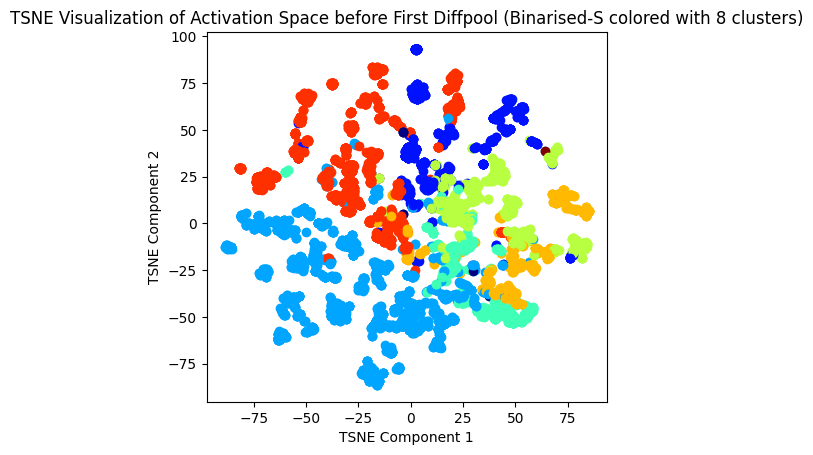

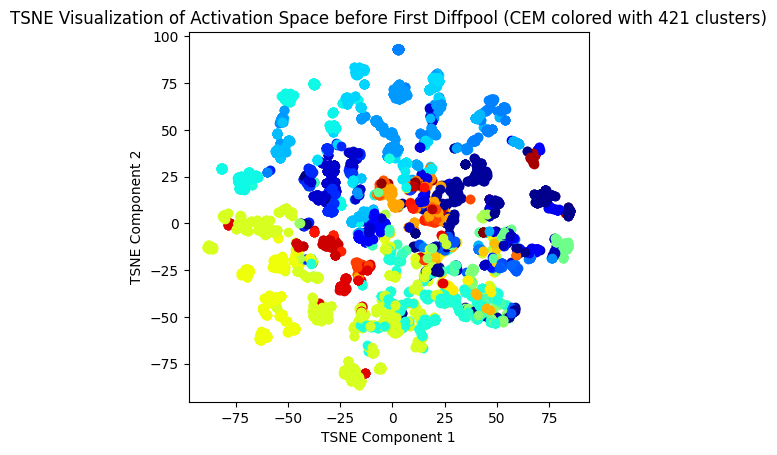

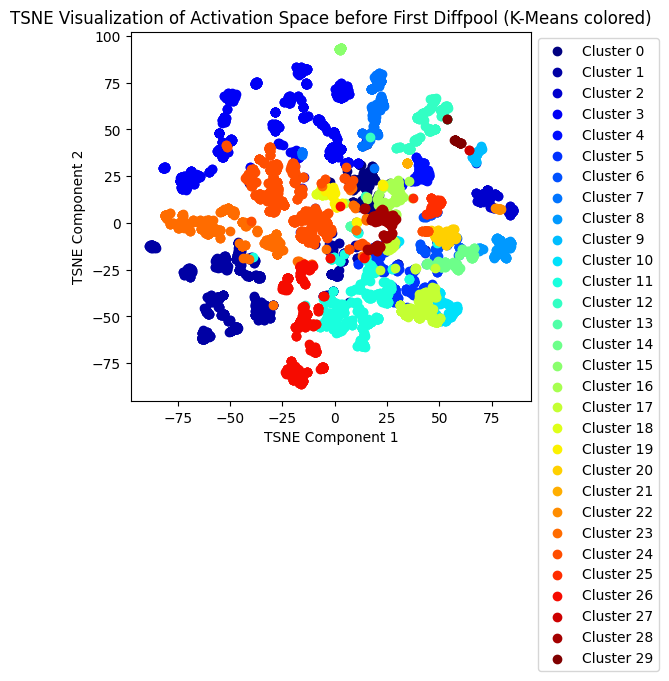

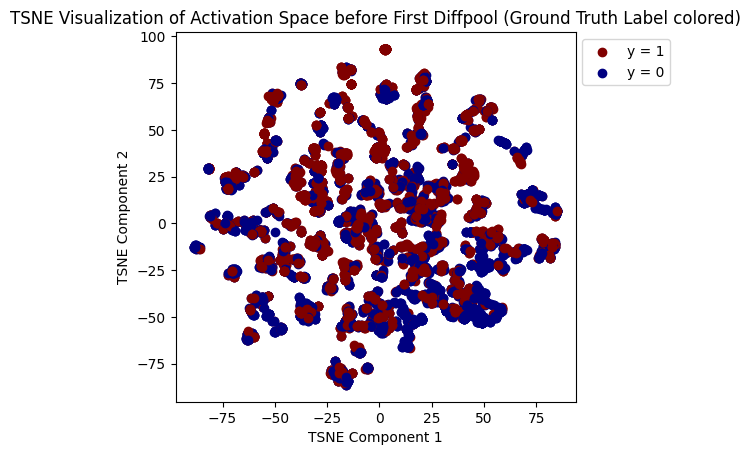

/Users/stella/anaconda3/envs/gdl/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


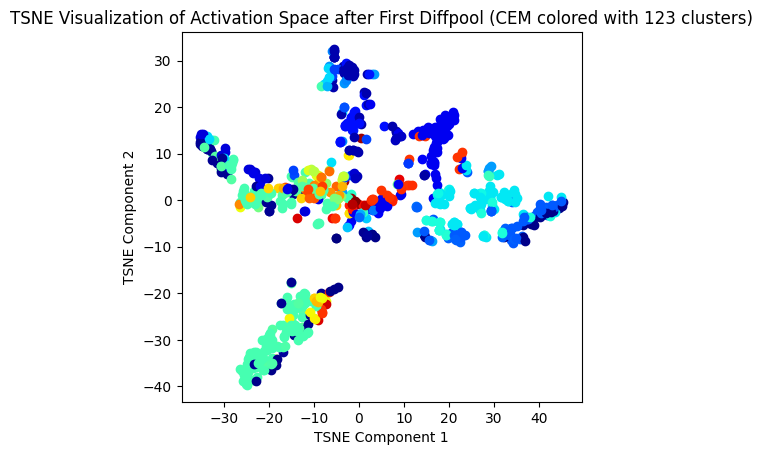

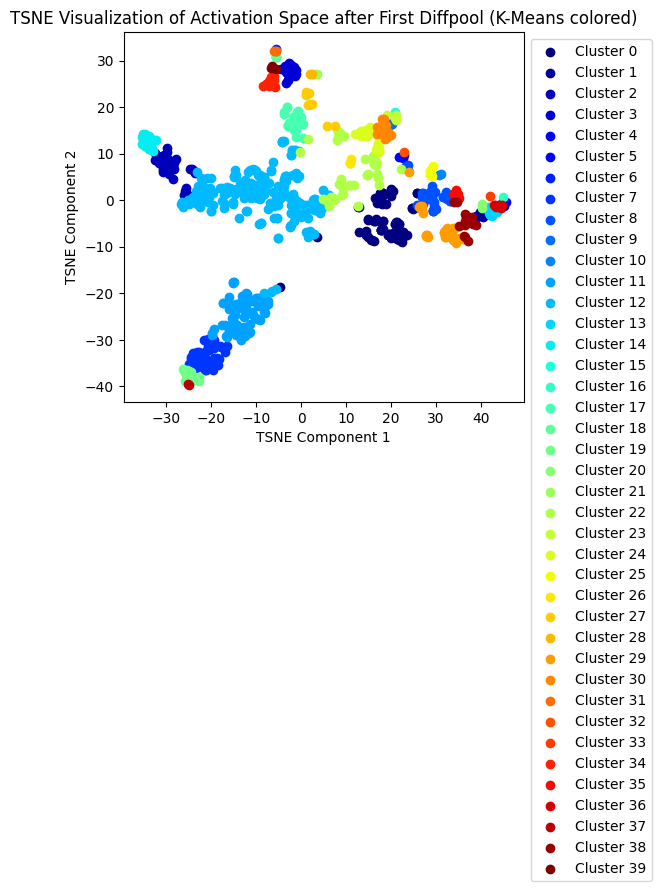

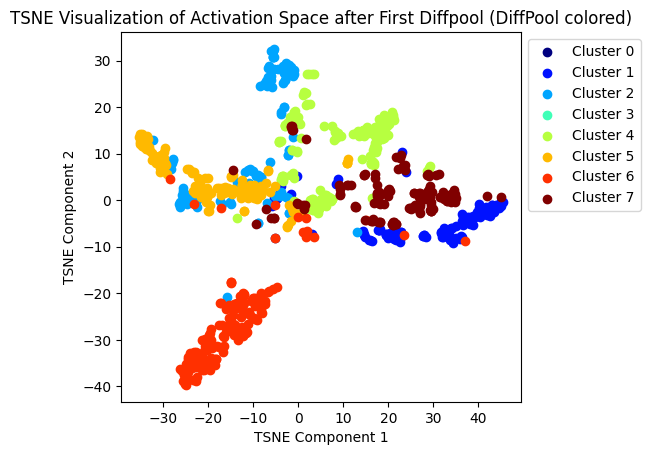

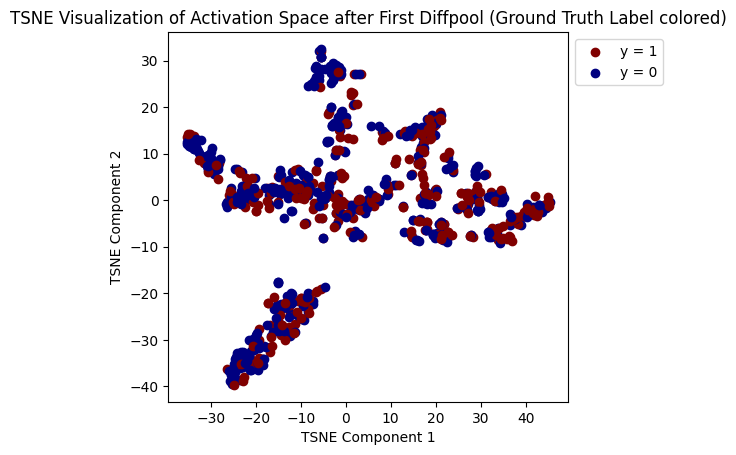

In [6]:
graph_nodes_enumerate = [list(range(n)) for n in graph_nodes]

labels, centroids = before_diffpool_plot(x_gnn1_embed, s_gnn1_pool, y_labels, graph_nodes_enumerate, 'TSNE', 30, 'First Diffpool')

labels_km, centroids, colors_km, colors_dp ,labels_dp, features_np, info_graph_node = after_diffpool_plot(out1, y_labels, graph_nodes_enumerate, cluster_assignments1, 'TSNE', 40, 'First Diffpool')

### Activation Space Before and After Second DiffPool Layer

/Users/stella/anaconda3/envs/gdl/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


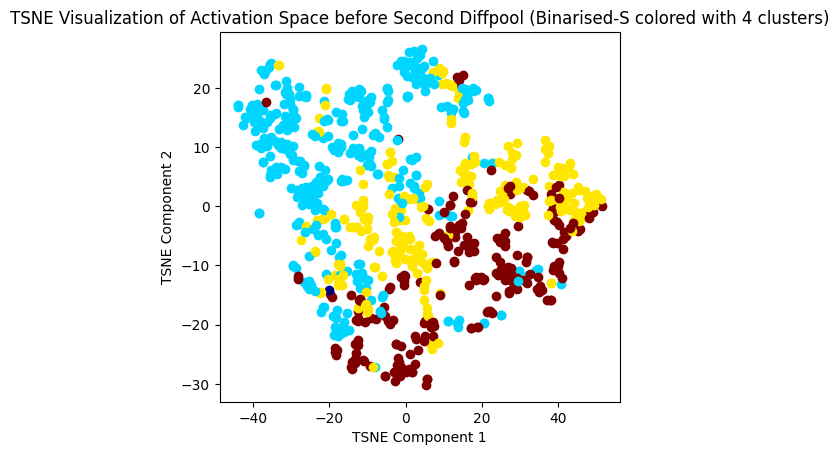

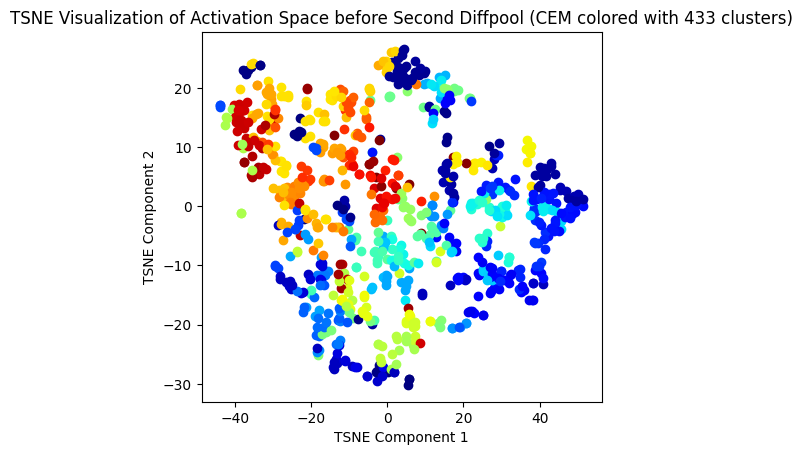

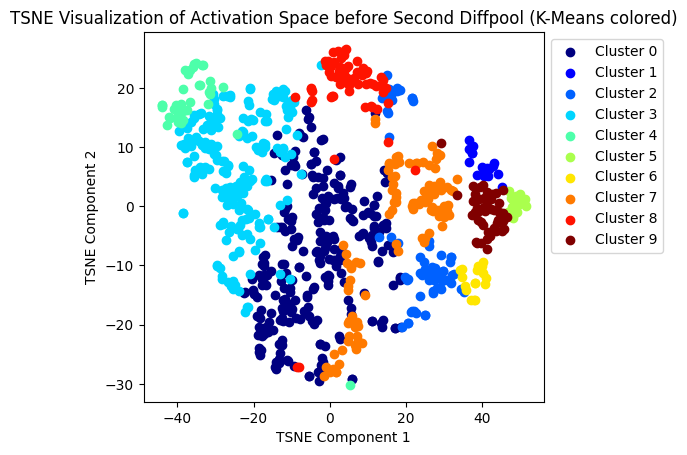

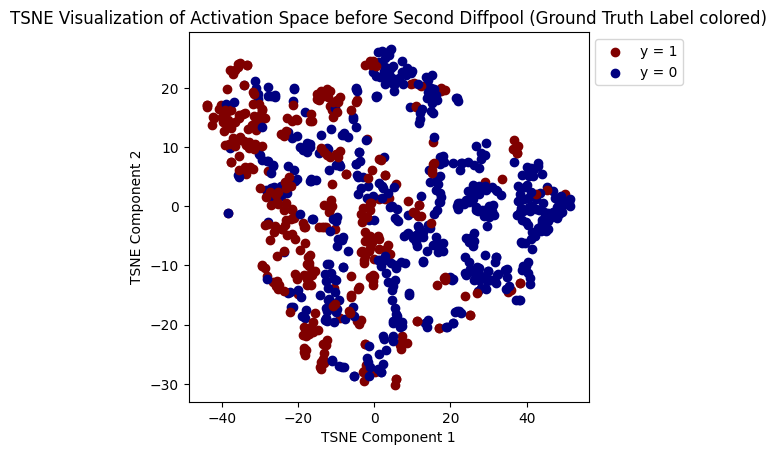

/Users/stella/anaconda3/envs/gdl/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


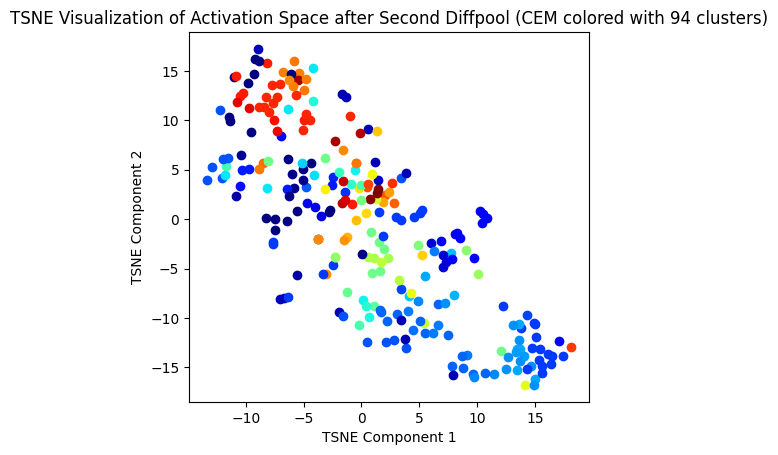

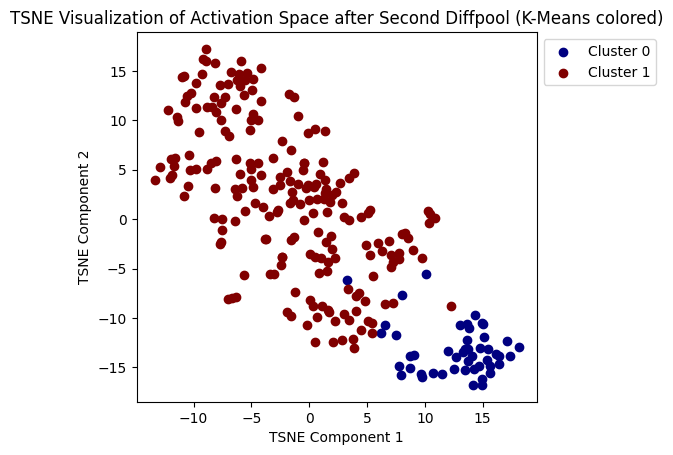

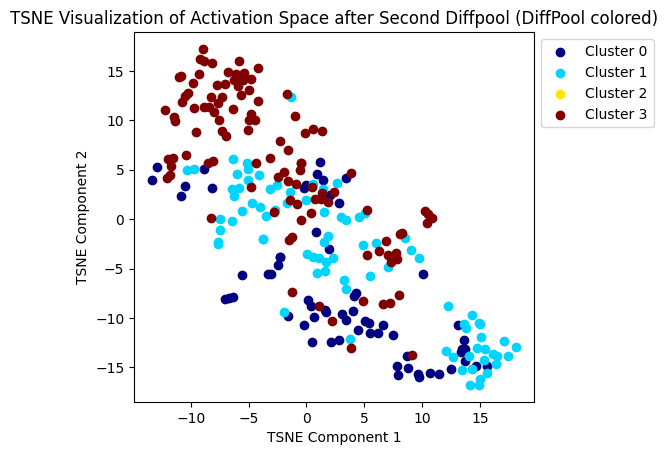

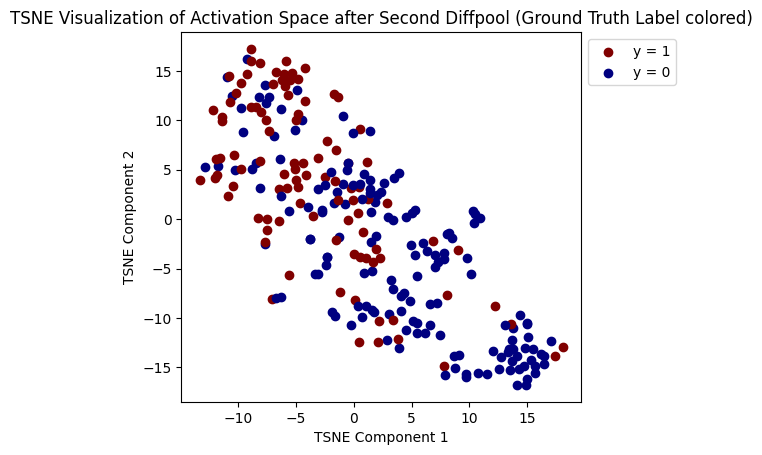

In [7]:
graph_nodes_enumerate_2 = []
for batch_idx in range(len(cluster_assignments1)):
    new_nodes = cluster_assignments1[batch_idx][:graph_nodes[batch_idx]]
    graph_nodes_enumerate_2.append(torch.unique(new_nodes).tolist())

labels_2, centroids_2 = before_diffpool_plot(x_gnn2_embed, s_gnn2_pool, y_labels, graph_nodes_enumerate_2, 'TSNE', 10, 'Second Diffpool')

labels_km_2, centroids_2, colors_km_2, colors_dp_2 ,labels_dp_2, features_np_2, info_graph_node_2 = after_diffpool_plot(out2, y_labels, graph_nodes_enumerate_2, cluster_assignments2, 'TSNE', 2, 'Second Diffpool')


### First DiffPool Concept Visualization

In [ ]:
top_closest_indices = find_top_closest(features_np, labels_km, centroids, 5) # finding the top 5 feature indexes that are closest to the center of each k-means cluster.

dp_centers = calculate_centroids_with_padding(features_np, labels_dp)

top_closest_indices_dp = find_top_closest(features_np, labels_dp, dp_centers, 5)


In [ ]:
# 5 nodes extracted from DiffPool Cluster
visualize_graphs_with_diffpool_clusters(data, top_closest_indices_dp, info_graph_node, labels, 'DiffPool', 'First DiffPool layer','40','8', cluster_assignments1, graph_nodes)

In [ ]:
# 5 nodes extracted from K-Means cluster
visualize_graphs_with_diffpool_clusters(data, top_closest_indices, info_graph_node, labels,'K-Means','First DiffPool layer','40','8', cluster_assignments1, graph_nodes)


### Second DiffPool Concept Visualization

In [ ]:
top_closest_indices_2 = find_top_closest(features_np_2,labels_km_2 ,centroids_2, 5) # finding the top 5 feature indexes that are closest to the center of each k-means cluster.

dp_centers_2 = calculate_centroids_with_padding(features_np_2, labels_dp_2)

top_closest_indices_dp_2 = find_top_closest(features_np_2, labels_dp_2, dp_centers_2, 5)

In [ ]:
graph_nodes_2 = []
for i in range(200):
  graph_nodes_2.append(len(graph_nodes_enumerate_2[i]))
visualize_graphs_with_2nddiffpool_clusters(new_graph_adj, top_closest_indices_dp_2, info_graph_node_2, labels_dp, 'DiffPool', 'Second DiffPool layer','32','4', cluster_assignments2, graph_nodes_2, graph_nodes_enumerate_2)
# cluster by 2nd diffpool cluster. Number on the node is the 1st diffpool cluster number

### Some Graph Ploting Trial (Please Ignore)

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np


def two_hop_neighbor(adj_matrix, target_node):
    """
    Input:
        adj_matrix
        target_node: target node idx for which we want to find the 2-hop neighborhood
    """
    # Create a graph
    G = nx.Graph()

    # Add edges based on the adjacency matrix
    n = len(adj_matrix)
    for i in range(n):
        for j in range(n):
            if adj_matrix[i][j] == 1:
                G.add_edge(i, j)

    # Draw the graph
    nx.draw(G, with_labels=True, node_color='lightblue', edge_color='gray')
    plt.show()

    
    # Find the 1-hop neighbors
    one_hop_neighbors = set(nx.neighbors(G, target_node))

    # Find the 2-hop neighbors
    two_hop_neighbors = set()
    for neighbor in one_hop_neighbors:
        two_hop_neighbors |= set(nx.neighbors(G, neighbor))

    # Combine 1-hop and 2-hop neighbors, and include the target node itself
    neighborhood = one_hop_neighbors | two_hop_neighbors | {target_node}

    # Create the subgraph
    subgraph = G.subgraph(neighborhood)

    # Draw the subgraph
    pos = nx.spring_layout(subgraph)  # positions for all nodes
    nx.draw(subgraph, pos, with_labels=True, node_color='lightblue', edge_color='gray')

    # Highlight the target node
    nx.draw_networkx_nodes(subgraph, pos, nodelist=[target_node], node_color='red')

    plt.show()


# Example Adjacency Matrix
adj_matrix = np.array([[0, 1, 0, 0, 0, 1],[1, 0, 1, 0, 0, 0],[0, 1, 0, 1, 0, 0],[0, 0, 1, 0, 1, 0],[0, 0, 0, 1, 0, 1], [1, 0, 0, 0, 1, 0]])
two_hop_neighbor(adj_matrix, 1)
